# Imports and Seeding

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D
# from google.colab import drive
print('Imports complete.')

Imports complete.


Using TensorFlow backend.


# Mount Google Drive, Read Data

In [2]:
# This will mount your personal drive. Note you'll need to authenticate.
# drive.mount('/content/drive')

In [3]:
# Google doesn't seem to currently support accessing a folder which is shared
# with you. So, I've uploaded 'all_data.csv' to my own drive. To run, you'll
# need to do the same.
# os.listdir('/content/drive/My Drive')
# TODO: Remove row limitation.
# df = pd.read_csv('/content/drive/My Drive/all_data.csv', index_col=0, parse_dates=True,
#                  infer_datetime_format=True) #, nrows=(1/5)*60*24*7*4)
df = pd.read_csv('all_data.csv', index_col=0, parse_dates=True,
                 infer_datetime_format=True)
# Why my 'tz_convert' line did nothing in combine_all_data.py, I don't know.
df.index = pd.to_datetime(df.index, utc=True)
# df.index = df.index.tz_localize('UTC')
df = df.tz_convert('America/New_York')
print('Data loaded.')

Data loaded.


In [4]:
print(df.head())
print(df.tail())
# print(df.info())
# Since our time is evenly spaced, linear interpolation should do.
# Why this didn't take in the script that created the file, I'm not sure.
df.interpolate(method='linear', inplace=True)
# After interpolation, there's just one NaN left. Use forward and backfilling.
df.fillna(method='ffill', inplace=True)
df.fillna(method='backfill', inplace=True)
# Confirm we got rid of all the NaNs.
nan_count = df.isna().sum()
nan_cols = nan_count > 0
print('Columns with NaNs:')
print(df.columns[nan_cols])
print('NaN counts:')
print(nan_count[nan_cols])

                           forecast_lbmp__capitl  forecast_lbmp__centrl  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  30.19                  13.04   
2016-01-01 00:05:00-05:00                  30.19                  13.04   
2016-01-01 00:10:00-05:00                  30.19                  13.04   
2016-01-01 00:15:00-05:00                  30.19                  13.04   
2016-01-01 00:20:00-05:00                  30.19                  13.04   

                           forecast_lbmp__dunwod  forecast_lbmp__genese  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  25.79                  12.45   
2016-01-01 00:05:00-05:00                  25.79                  12.45   
2016-01-01 00:10:00-05:00                  25.79                  12.45   
2016-01-01 00:15:00-05:00                  25.79                  12.45   
2016-01-01 00:20:00-05:0

Columns with NaNs:
Index([], dtype='object')
NaN counts:
Series([], dtype: int64)


# Shift realtime data ahead by one hour

In [5]:
# We'll predict the lbmp in NYC.
pred_col = 'realtime_lbmp__nyc'

# First, extract the column we'll be making predictions on.
y = df[pred_col].copy(deep=True)

# Loop over the columns.
for c in df.columns:
    # In combine_all_data.py, all realtime data was prefixed with 'realtime_'.
    # When we encounter a realtime column, shift it by 12 spots (1 hour for
    # 5 minute intervals.)
    if c.startswith('realtime_'):
        df[c] = df[c].shift(12)

# After shifting the realtime data ahead, we have NaNs in our first
# 12 rows. Drop them.
df.dropna(inplace=True)

# Drop the same rows in y.
y = y[df.index]

print(y.head())
print(df[pred_col].head())

print('Realtime data shifted.')

# print(df.head())

Time Stamp
2016-01-01 01:00:00-05:00    45.27
2016-01-01 01:05:00-05:00    20.00
2016-01-01 01:10:00-05:00    19.00
2016-01-01 01:15:00-05:00    24.38
2016-01-01 01:20:00-05:00    47.00
Name: realtime_lbmp__nyc, dtype: float64
Time Stamp
2016-01-01 01:00:00-05:00     18.82
2016-01-01 01:05:00-05:00     18.82
2016-01-01 01:10:00-05:00    230.87
2016-01-01 01:15:00-05:00     54.19
2016-01-01 01:20:00-05:00     38.38
Name: realtime_lbmp__nyc, dtype: float64
Realtime data shifted.


# Split Data Into Testing vs. Training, Extract Feature We'll be Predicting

In [6]:
# Let's look at realtime LBMP in NYC.
# No need to drop features since we extracted 'y' before shifting all the realtime data.
x = df

# TODO: We probably shouldn't be using real-time data in training/predicting,
# right? This should maybe be a two-step process: Predict 5-minute real-time 
# (will need another network/model to do that), then plug that in for LMP
# training/predicting.
y_train = y['2016':'2017']
y_test = y['2018']
x_train = x['2016':'2017']
x_test = x['2018']

print('Data split for train vs. test.')

Data split for train vs. test.


# Scale Data

In [7]:
# We'll use "standard" scaling
# Scale y data.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# 
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train.values)
x_test_scaled = scaler_x.transform(x_test.values)
print('Data has been scaled.')

# Ensure we have no NaNs.
np.isnan(x_train_scaled).any()

Data has been scaled.


False

# Use Lasso to determine important features

In [8]:
lasso = LassoCV(cv=5, max_iter=100000, n_jobs=-1, fit_intercept=False)
lasso.fit(x_train_scaled, y_train_scaled.ravel())
print('Alpha: {}'.format(lasso.alpha_))
# print('Coefficients:')
# print(lin_reg.coef_)
non_zero = lasso.coef_ != 0.0
print('Number of non-zero coefficients: {}'.format((non_zero).sum()))
print('Features:')
features_lasso = df.columns.values[non_zero]
print(features_lasso)

Alpha: 0.0185282626201218
Number of non-zero coefficients: 17
Features:
['forecast_lbmp__dunwod' 'forecast_lbmp__longil' 'forecast_lbmp__nyc'
 'forecast_marginal_cost_losses__capitl'
 'forecast_marginal_cost_losses__pjm' 'realtime_lbmp__capitl'
 'realtime_lbmp__longil' 'realtime_lbmp__mhkvl' 'realtime_lbmp__nyc'
 'realtime_marginal_cost_losses__genese'
 'realtime_marginal_cost_losses__hq'
 'realtime_marginal_cost_losses__north'
 'realtime_marginal_cost_losses__oh'
 'realtime_marginal_cost_congestion__genese' 'realtime_load_millwd'
 'relativehumidity_a' 'windspeed_i']


Coefficients:
[ 0.14141797  0.11684023  0.04218273 -0.00608498  0.02870531  0.07185611
  0.01284545  0.05005215  0.15520194 -0.0932728   0.04767164  0.02384489
  0.12302205  0.11821404  0.05503059  0.03510136 -0.02610469]


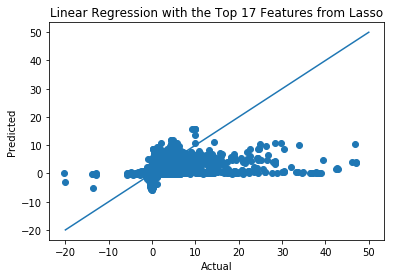

In [9]:
# Perform a simple linear regression with the non-zero lasso coefficients.
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(x_train_scaled[:, non_zero], y_train_scaled.ravel())
print('Coefficients:')
print(lin_reg.coef_)
y_pred = lin_reg.predict(x_test_scaled[:, non_zero])

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression with the Top {} Features from Lasso'.format(len(lin_reg.coef_)))
plt.show()

# Use Random Forest to determine important features

In [10]:
# Create RandomForest classifier
# Original results came from n_estimators=1000, max_depth=7.
# Rolling that back to n_estimators=500, max_depth=5
# NOTE: It looks like our top ten features come out to be the same-ish.
rf = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1, max_depth=5)
rf.fit(x_train_scaled, np.ravel(y_train_scaled))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
# Display the top features.
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# print feature importances in descending order
for f in range(15):
    print("{}. feature {} ({})".format(f + 1, df.columns[indices[f]],
                                       importances[indices[f]]))
    
# Grab as many features as we got from Lasso.
features_rf = df.columns.values[indices[0:len(features_lasso)]]

1. feature realtime_lbmp__nyc (0.37525738969255995)
2. feature forecast_load_hudvl (0.10161565152566736)
3. feature forecast_marginal_cost_congestion__genese (0.07304440975386955)
4. feature forecast_marginal_cost_congestion__west (0.06369285153671604)
5. feature windspeed_a (0.04292468739453225)
6. feature forecast_lbmp__pjm (0.03791740786329071)
7. feature realtime_marginal_cost_congestion__genese (0.02979590374397821)
8. feature realtime_load_capitl (0.02442665455361339)
9. feature realtime_marginal_cost_congestion__west (0.022693391742802063)
10. feature realtime_load_mhkvl (0.02139565172277501)
11. feature forecast_lbmp__nyc (0.017890800668073515)
12. feature realtime_lbmp__longil (0.01596265665614748)
13. feature relativehumidity_i (0.01256203314001334)
14. feature realtime_marginal_cost_losses__west (0.009334067634002683)
15. feature realtime_marginal_cost_losses__genese (0.008339788548220149)


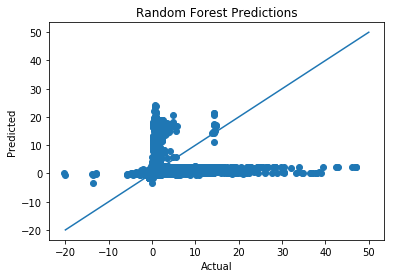

In [12]:
y_pred = rf.predict(x_test_scaled)

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')
plt.show()

# Compare Lasso and RandomForest features

In [14]:
common_features = set(features_lasso) & set(features_rf)
print('{} common features from Lasso and RandomForest:'.format(len(common_features)))
print(common_features)

# Let's grab the top 10 RF features and the top 10 Lasso features and create the intersection.
# Start by creating a dictionary of Lasso features.
lasso_dict = {}
for ind, col in enumerate(features_lasso):
    lasso_dict[col] = abs(lin_reg.coef_[ind])
    
# Sort.
lasso_top_ten = sorted(lasso_dict.items(), key=lambda kv: kv[1], reverse=True)
lasso_top_ten = [x[0] for x in lasso_top_ten[0:10]]

print('')
print('Top ten features for Lasso and RandomForest:')
top_ten_df = pd.DataFrame({'Lasso': lasso_top_ten, 'RandomForest': features_rf[0:10]})
print(top_ten_df)

# Take the union of the top ten features for both models.
features_to_use = list(set(lasso_top_ten) | set(features_rf[0:10]))
# print('')
# print('Union of top ten Lasso and top ten RF features ({} features):'.format(len(features_to_use)))
# print(features_to_use)

# Get the indices of these features in the original DataFrame.
col_list = list(df.columns.values)
feature_indices = [col_list.index(x) for x in features_to_use]

# Check.
print('Expected features:')
print(features_to_use)
print('Feautures reference by index:')
print(list(df.columns.values[feature_indices]))

6 common features from Lasso and RandomForest:
{'realtime_marginal_cost_losses__genese', 'forecast_lbmp__nyc', 'realtime_marginal_cost_losses__oh', 'realtime_lbmp__nyc', 'realtime_lbmp__longil', 'realtime_marginal_cost_congestion__genese'}

Top ten features for Lasso and RandomForest:
                                       Lasso  \
0                         realtime_lbmp__nyc   
1                      forecast_lbmp__dunwod   
2          realtime_marginal_cost_losses__oh   
3  realtime_marginal_cost_congestion__genese   
4                      forecast_lbmp__longil   
5      realtime_marginal_cost_losses__genese   
6                      realtime_lbmp__capitl   
7                       realtime_load_millwd   
8                       realtime_lbmp__mhkvl   
9          realtime_marginal_cost_losses__hq   

                                RandomForest  
0                         realtime_lbmp__nyc  
1                        forecast_load_hudvl  
2  forecast_marginal_cost_congestion__genese

# Extract most important features

In [45]:
# Save data to file so we can use other notebooks to do the ML.
pd.DataFrame(data=x_train_scaled[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_train.csv')
pd.DataFrame(data=x_test_scaled[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_test.csv')

pd.Series(data=y_train_scaled.ravel(), name=pred_col).to_csv('y_train.csv')
pd.Series(data=y_test_scaled.ravel(), name=pred_col).to_csv('y_test.csv')
print('Scaled data saved to file.')

(210516, 18)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


Scaled data saved to file.
